# Y3
## Javier Jorganes Villanueva 24.11.2023

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
plt.rcParams['figure.figsize'] = (12, 5)

In [3]:
df = pd.read_csv('v2.csv')
time = (df['timestamp'] - df['timestamp'][0])/1000
acc_x = df['x_acc']
acc_y = df['y_acc']
acc_z = df['z_acc']

## Plot plot plot:
- Aloitin luomalla funktio millä voin plotata myöhemmin kakki akselit helposti:

In [4]:
def plot_column(time, column, ymin, ymax, title, ylabel, xlabel, color):
    plt.plot(time, column, color=color)
    plt.ylim(ymin, ymax)
    plt.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

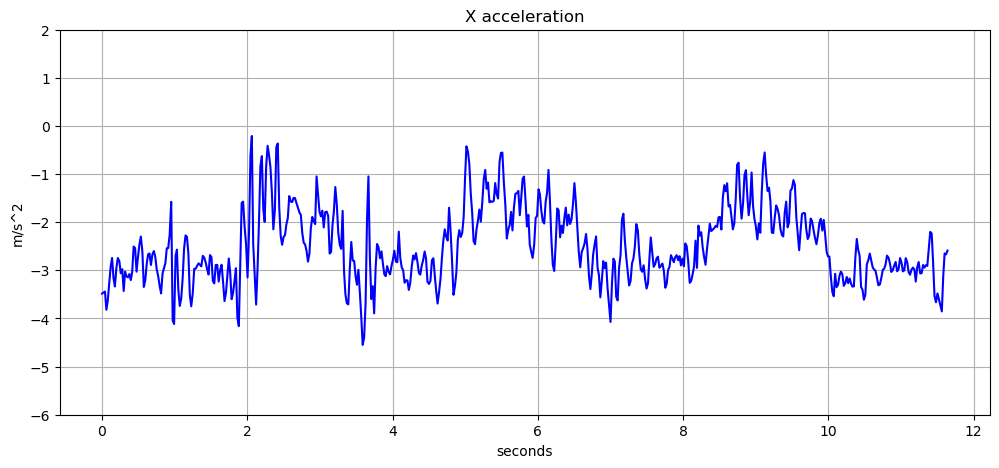

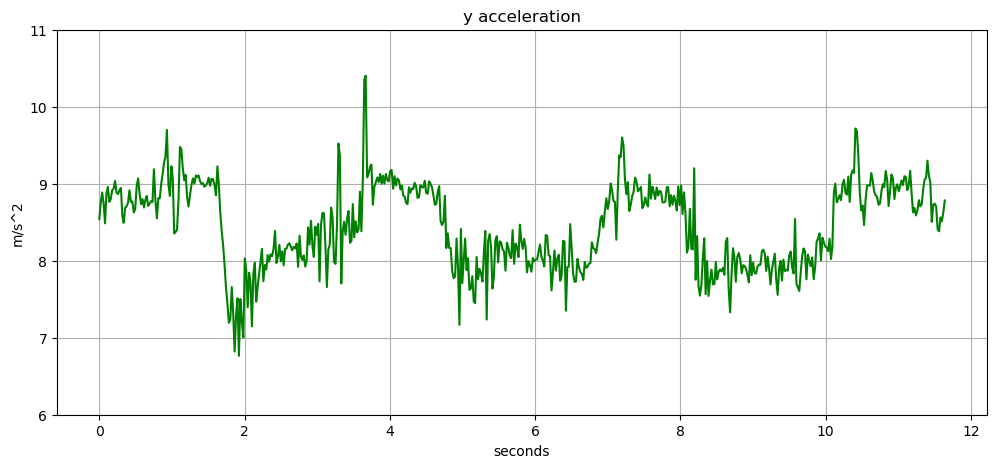

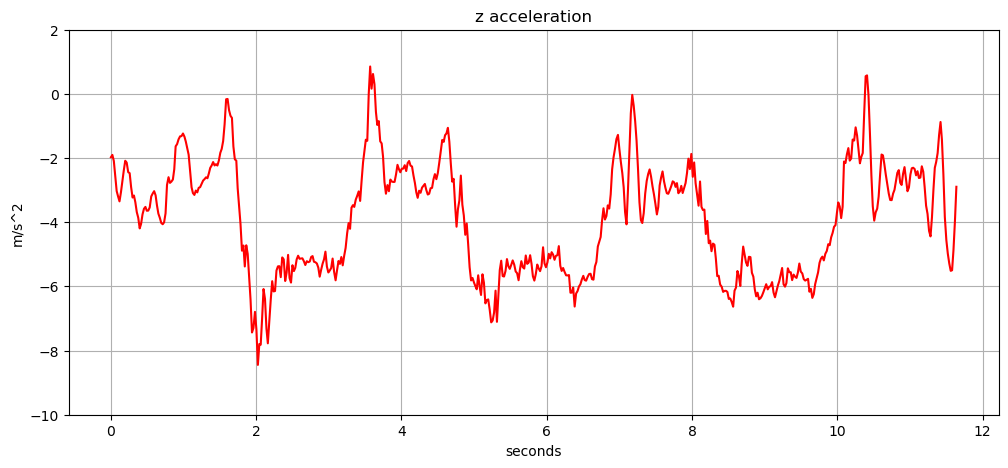

In [5]:
plot_column(time, acc_x,-6,2,'X acceleration','m/s^2','seconds','blue')
plot_column(time, acc_y,6,11,'y acceleration','m/s^2','seconds','green')
plot_column(time, acc_z,-10,2,'z acceleration','m/s^2','seconds','red')

## Suodatus:

Tässä on kokeiltu muutama vaihtoehtoja mutta lopussa valitsin seuraava tapa:

```python
alpha = 0.1
b = np.array([alpha])
a = np.array([1, -(1 - alpha)])
zi = signal.lfiltic(b, a, acc_x)
acc_x_e2, zo = signal.lfilter(b, a, acc_x, zi = zi)
plot_acc_x(time, acc_x_e2)
```

Valitsin sen koska alpha muokkaamalla on paljon helpompi (omasta mielestä) säädellä kuinka paljon haluan suodata signaalia. Tästä vaihtoehdosta tein "filtro" funktio joten voi helposti käyttää muilla dataframen kolumneilla.
Se näkee seuraavaksi:

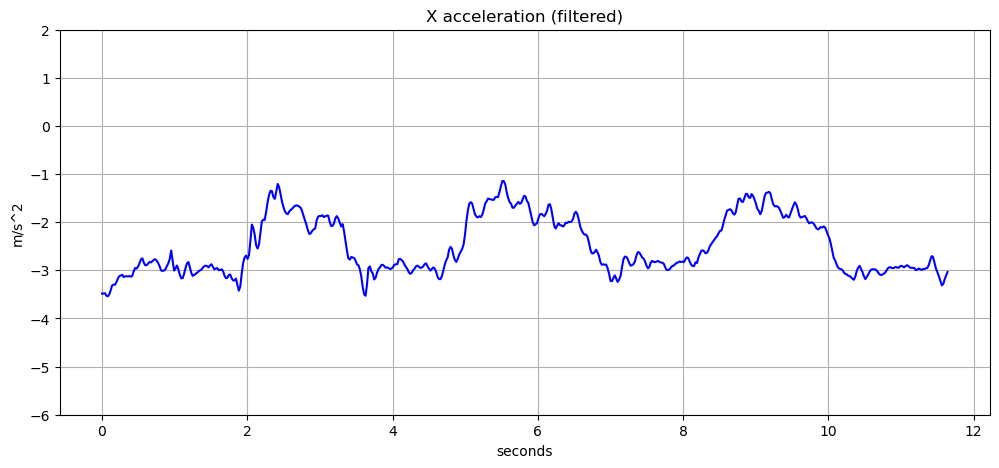

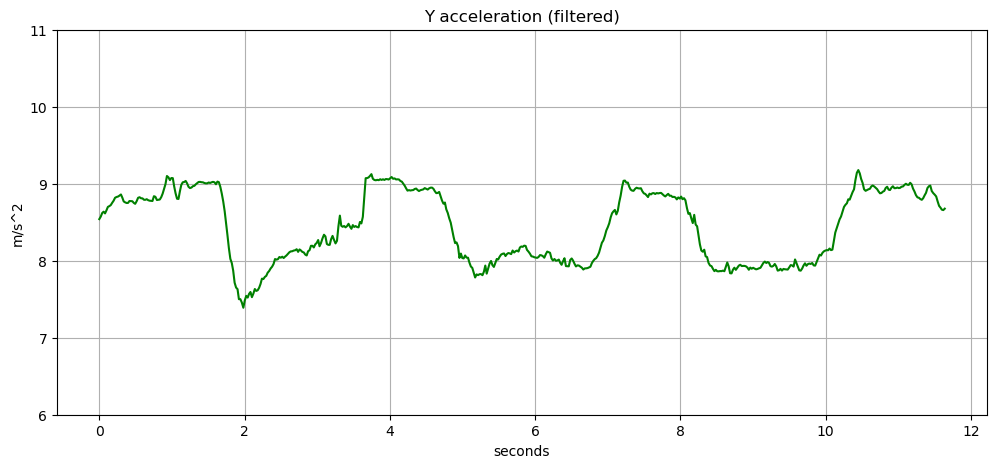

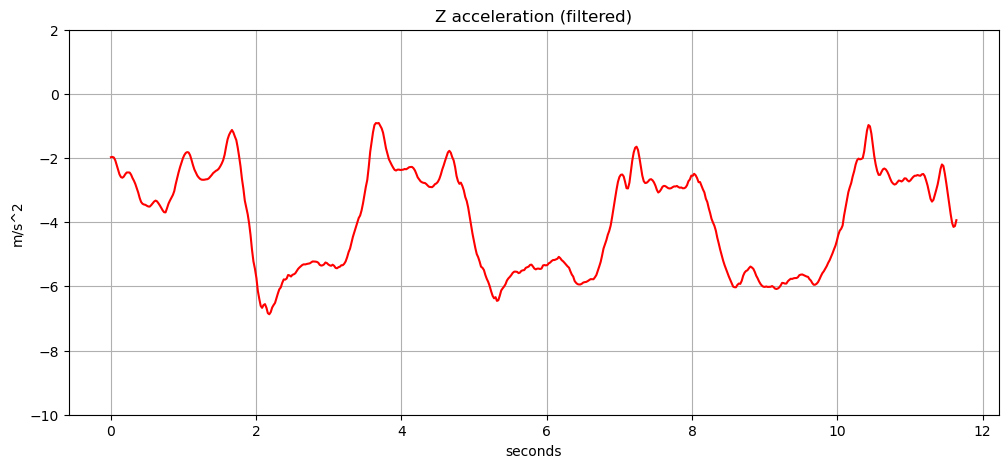

In [6]:
def filtro(alpha, column):
    b = np.array([alpha])
    a = np.array([1, -(1 - alpha)])
    zi = signal.lfiltic(b, a, column)
    column_f, zo = signal.lfilter(b, a, column, zi=zi)
    return column_f

# Use the function and store the result in a variable
f_acc_x = filtro(0.15, acc_x)
f_acc_y = filtro(0.15, acc_y)
f_acc_z = filtro(0.15, acc_z)

# Now plot using the filtered data
plot_column(time, f_acc_x, -6, 2,'X acceleration (filtered)','m/s^2','seconds','blue')
plot_column(time, f_acc_y, 6,11,'Y acceleration (filtered)','m/s^2','seconds','green')
plot_column(time, f_acc_z, -10, 2,'Z acceleration (filtered)','m/s^2','seconds','red')

## Seuraavaksi aloitetaan työskentely gyrometrin datalla:
Valitsin kolumnit dataframista seuraavalla tavalla:

In [7]:
gyro_x = df['x_gyro']
gyro_y = df['y_gyro']
gyro_z = df['z_gyro']

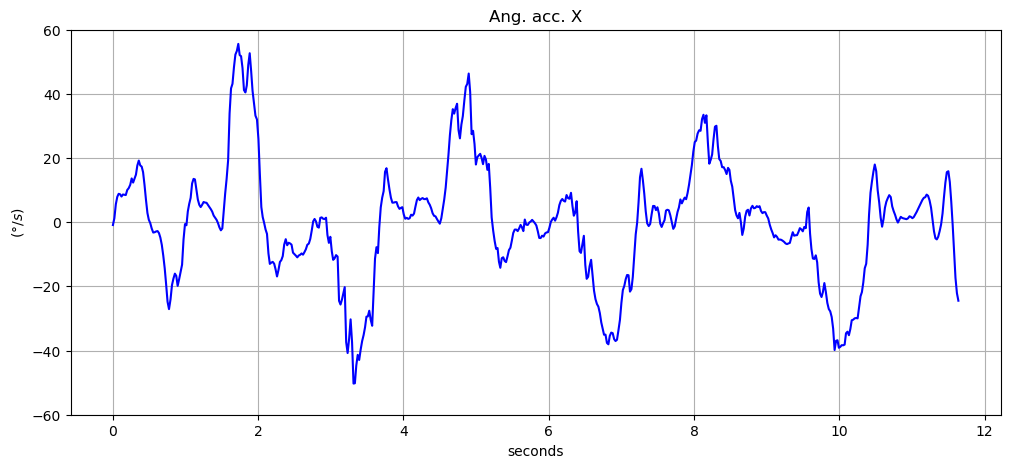

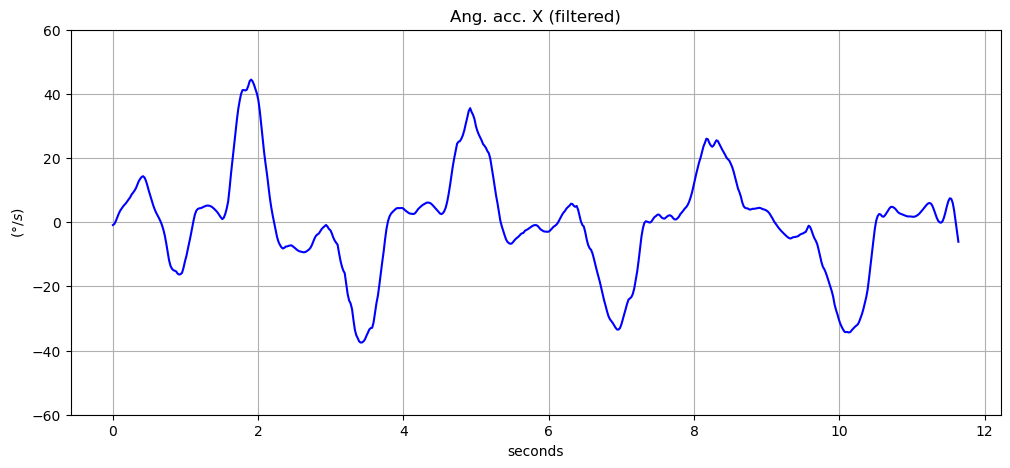

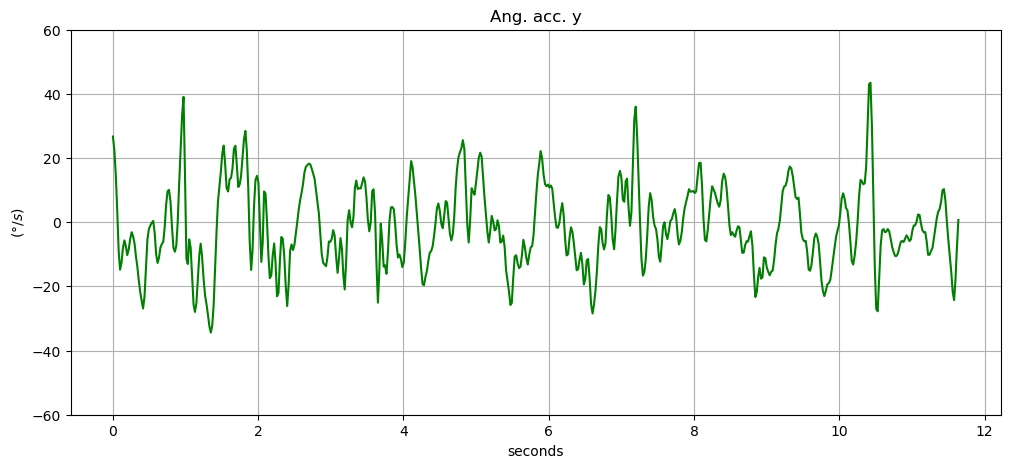

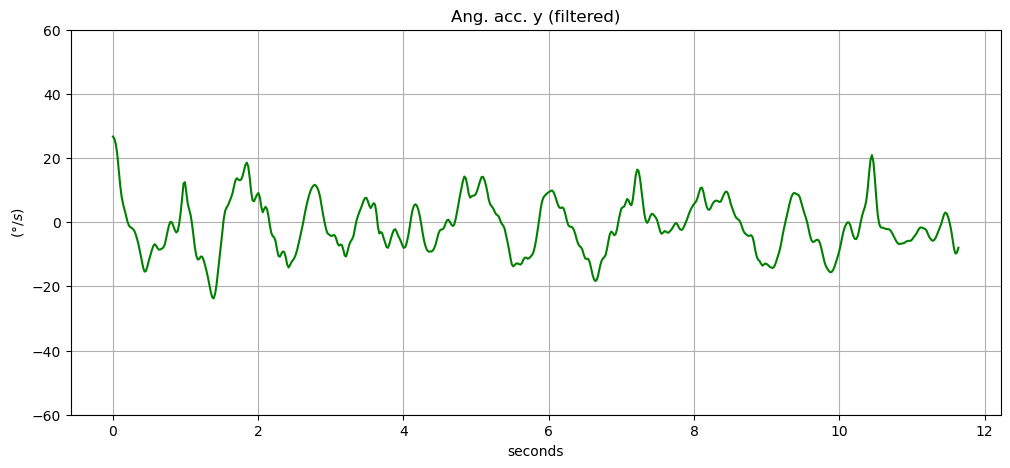

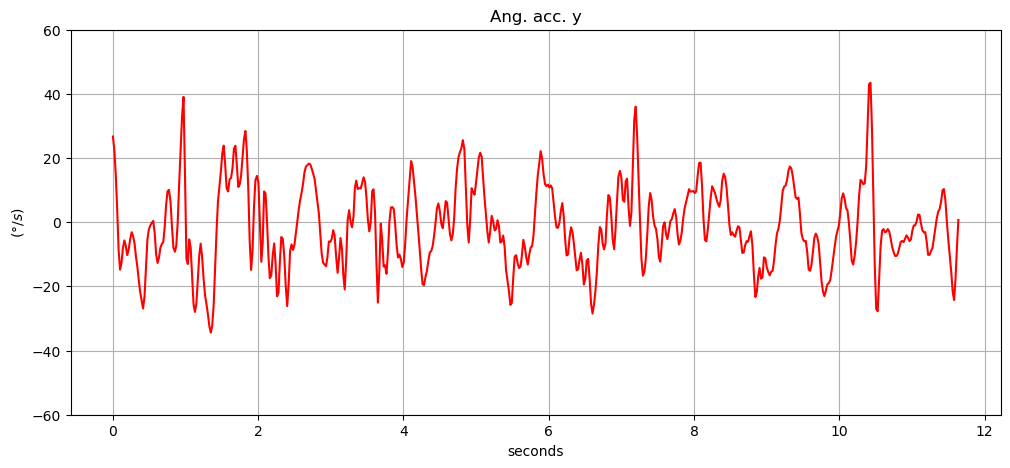

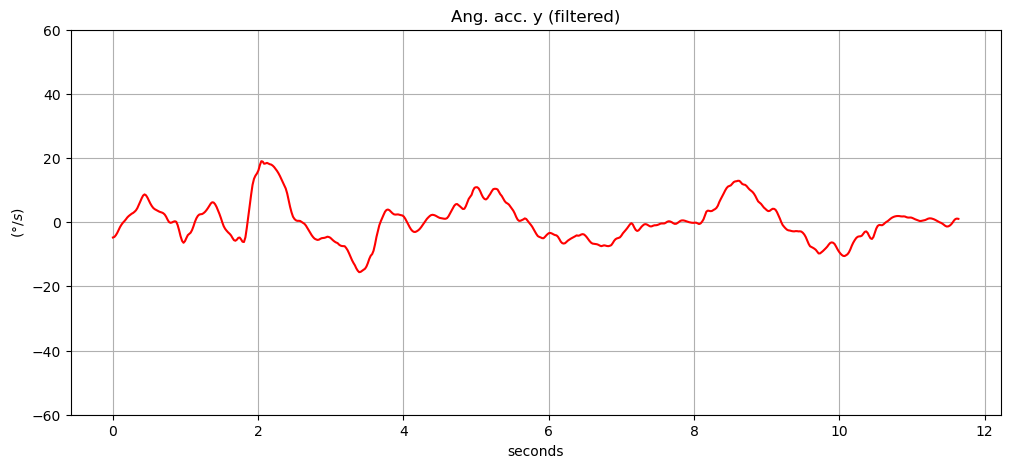

In [8]:
plot_column(time, gyro_x,-60,60, 'Ang. acc. X','($\degree/s$)','seconds','blue')
f_gyro_x = filtro(0.15,gyro_x)
plot_column(time, f_gyro_x,-60,60,'Ang. acc. X (filtered)','($\degree/s$)','seconds','blue')

plot_column(time, gyro_y,-60,60, 'Ang. acc. y','($\degree/s$)','seconds','green')
f_gyro_y = filtro(0.15,gyro_y)
plot_column(time, f_gyro_y,-60,60,'Ang. acc. y (filtered)','($\degree/s$)','seconds','green')

plot_column(time, gyro_y,-60,60, 'Ang. acc. y','($\degree/s$)','seconds','red')
f_gyro_z = filtro(0.15,gyro_z)
plot_column(time, f_gyro_z,-60,60,'Ang. acc. y (filtered)','($\degree/s$)','seconds','red')

## Miten valitsin tietyn aikavälin.
 - Tämä on tärkeä koska muutajat "ka_" käytetään loppuvaiheessa kun luodaan histogrammia.
 - Valitsin koen ajasta aikavälin mitä halusin analysoida ja laskin sen keskiarvo seuraavaksi:

In [9]:
# samples in specific period of time and average in the kulmasiirtymä inside that period.
mask_x = (time > 1.6) & (time < 9.3)
ka_x = f_gyro_x[mask_x].mean()
print(f'mean in selected period of time (x)= {ka_x:.3f} deg/s') #.3f = 3 decimals after point

mask_y = (time > 6) & (time < 11)
ka_y = f_gyro_y[mask_y].mean()
print(f'mean in selected period of time (y)= {ka_y:.3f} deg/s') #.3f = 3 decimals after point

mask_z = (time > 2) & (time < 7.3)
ka_z = f_gyro_z[mask_z].mean()
print(f'mean in selected period of time (z) = {ka_z:.3f} deg/s') #.3f = 3 decimals after point


mean in selected period of time (x)= 1.747 deg/s
mean in selected period of time (y)= -1.190 deg/s
mean in selected period of time (z) = -0.096 deg/s


# Miten käyetetään butterworthia:

- Olen aikaisemmin kokeillut toinen suodatin joka laitan alle, mutta tulos oli hieman vialinen ja ei niin luotettava kuin butterworh suodatin. 
```python
# Näytteenottoaika
ts = 1/50 # sec
print(ts)
# Karkea numeerinen integrointi laskemalla kumulatiivinen summa ja kertomalla näytteenottoajalla
f_gyro_x_int = f_gyro_x.cumsum()*ts
plot_column(time, f_gyro_x_int,-10,30,'X gyro','Angular Position ($\degree$)','seconds','blue')
#pitää muistaa että tämä on X akseli, meillä tarkoittaa "vasemmasta -> oikeaan (tai vastapäin)"
# Meillä Y akseli kertoo "ylhäältä alaspäin tai vastapäin"
```

- Seuraavaksi laitan copy-paste keskustelusta chat gpt.n kanssa joka auttoi ymmärttämään miksi minun piti muokata tajuus omassa koodissa jos haluan käyttää butterworth suodatin:

## Designing the Butterworth High-Pass Filter:

   - b, a = signal.butter(3, 0.2, btype='high', fs=104):
        - signal.butter() is a function from the SciPy library's signal processing module. It is used to design a Butterworth filter, which is a type of signal filter with a maximally flat frequency response in the passband.
        - The first argument 3 is the order of the filter. The order of the filter determines the steepness of the filter's response curve. A higher order means a steeper roll-off.
        - The second argument 0.2 is the critical frequency for the high-pass filter. This value is typically a fraction of the Nyquist frequency, which is half the sampling rate. Here, it is specified in normalized form, where 1 corresponds to the Nyquist frequency (fs/2), so 0.2 means the filter's cutoff frequency is 0.2 times the Nyquist frequency.
        - btype='high' specifies that the filter is a high-pass filter, meaning it will allow frequencies higher than the cutoff frequency to pass through while attenuating frequencies lower than the cutoff frequency.
        - fs=104 specifies the sampling rate of the signal. This is used to correctly calculate the normalized cutoff frequency.
        
## My case:

    - If the sampling rate (fs) of your signal is 50 Hz, you would need to adjust the filter design to accommodate this new sampling rate. The critical frequency, which is the cutoff frequency of the filter, should be specified relative to the Nyquist frequency, which is half of the sampling rate.
    
    In the original code, the critical frequency was 0.2 in normalized units, where 1 represents the Nyquist frequency (half of the original sampling rate fs=104 Hz, so Nyquist was 104/2 = 52 Hz, and the cutoff was 0.2 * 52 Hz).
    For your case, with fs = 50 Hz, the Nyquist frequency is 50/2 = 25 Hz. If you wish to maintain the same cutoff frequency in Hz as before, you would need to calculate the new normalized cutoff frequency relative to the new Nyquist frequency.
    
    For example, if your original cutoff frequency was 0.2 * 52 Hz (approximately 10.4 Hz), you would calculate the normalized cutoff for the new sampling rate like this:
    Normalized cutoff frequency = cutoff frequency in Hz / Nyquist frequency = 10.4 Hz / 25 Hz

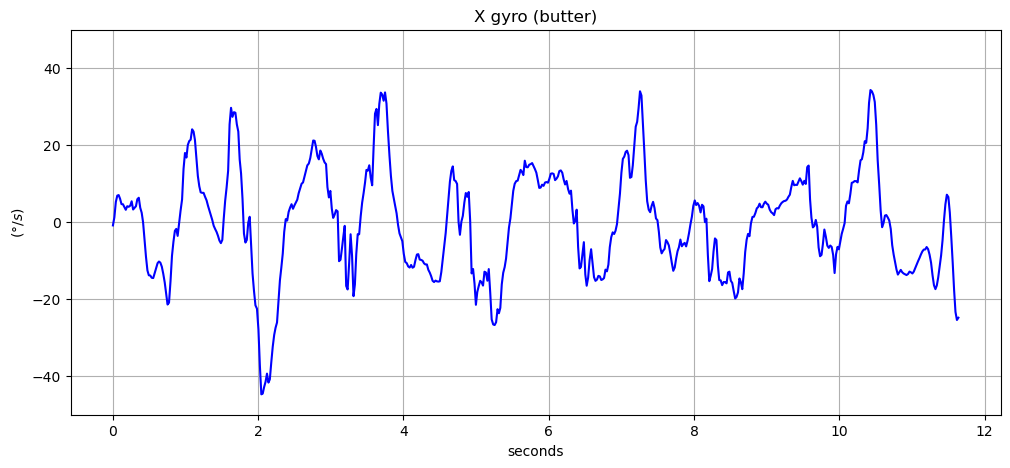

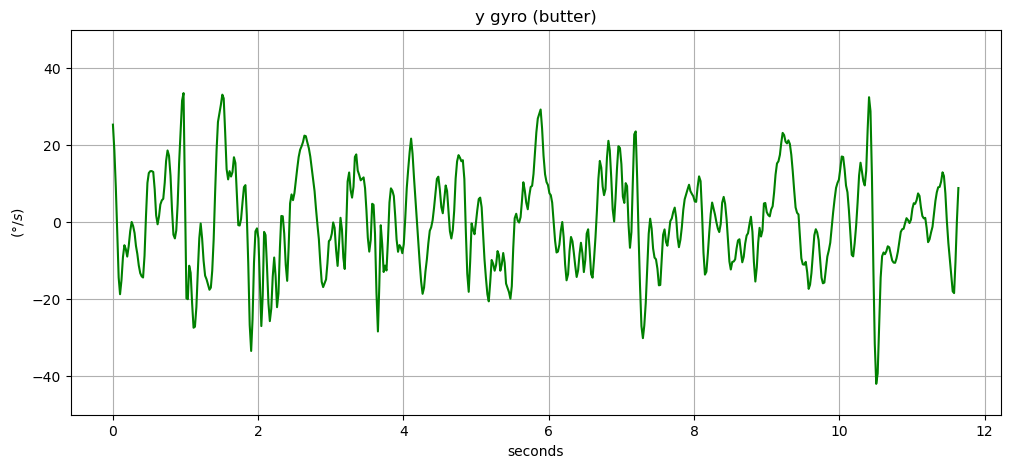

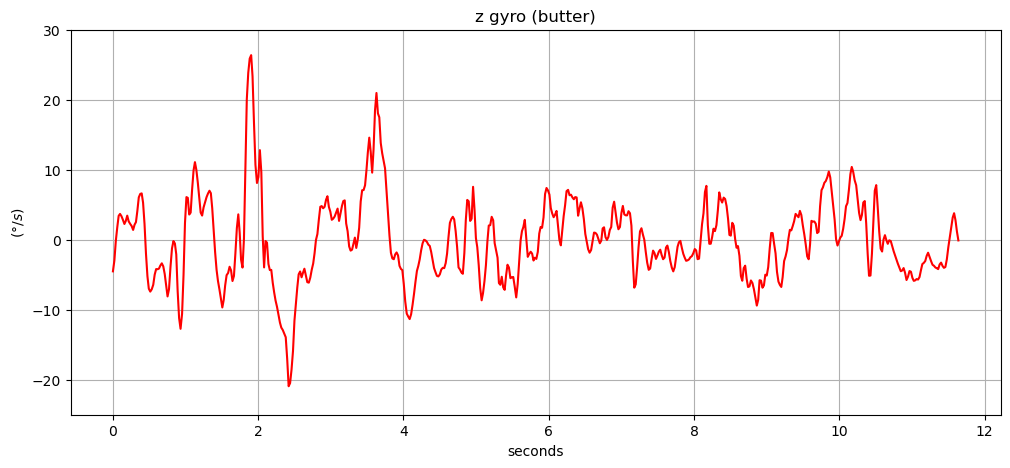

In [10]:
# Suunnittele Butteworth ylipäästösuodatin
b, a = signal.butter(3, 0.416, btype = 'high', fs = 50) #cutoff freq = 0.416
# Normalized cutoff frequency = cutoff frequency in Hz / Nyquist frequency = 10.4 Hz / 25 Hz

# Suodata kulmanopeusdata suodattimella
gyro_x_filt = signal.lfilter(b, a, gyro_x)
plot_column(time, gyro_x_filt,-50,50,'X gyro (butter)','($\degree/s$)','seconds','blue')

gyro_y_filt = signal.lfilter(b, a, gyro_y)
plot_column(time, gyro_y_filt,-50,50,'y gyro (butter)','($\degree/s$)','seconds','green')

gyro_z_filt = signal.lfilter(b, a, gyro_z)
plot_column(time, gyro_z_filt,-25,30,'z gyro (butter)','($\degree/s$)','seconds','red')

## Kulmanopeudesta -> Kulmasiirtymään
## degree/s^2 -> degree
- Tätä varten pitää integroida meidän datan seuravaalla tavalla:
```python
gyro_x_int2 = gyro_x_filt.cumsum()/50 # Integrated data, so we can get the (VERY IMPORTANT): ANGULAR POSITION
plot_column(time, gyro_x_int2,-10,10,'X gyro','Angle position ($\degree$)','seconds','blue')
```


## Miksti tarvitaan integroida meidän datan?

- ANGULAR DISPLACEMENT -> INTEGRATION -> ANGULAR POSITION
- Seuraavaksi screenshotin selityksestä:

<img src="gptexplainsangularp.png" alt="gpt explains" width="600"/>


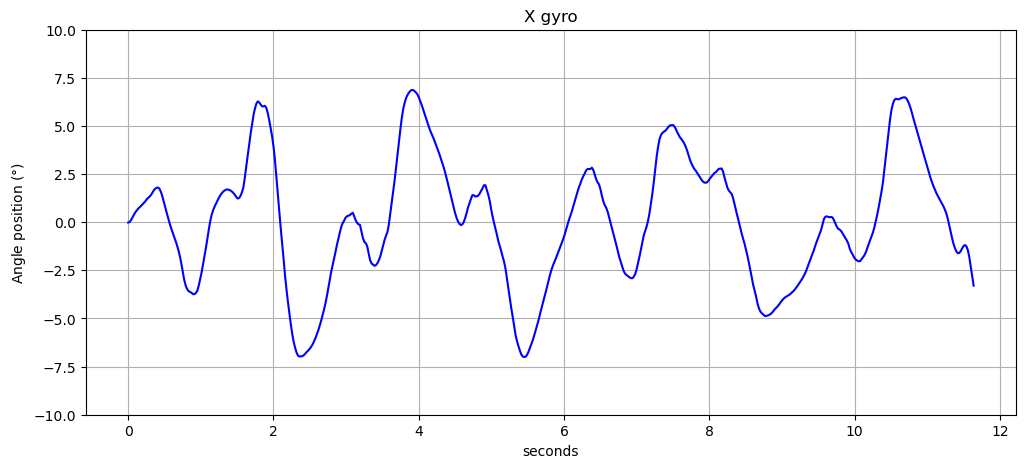

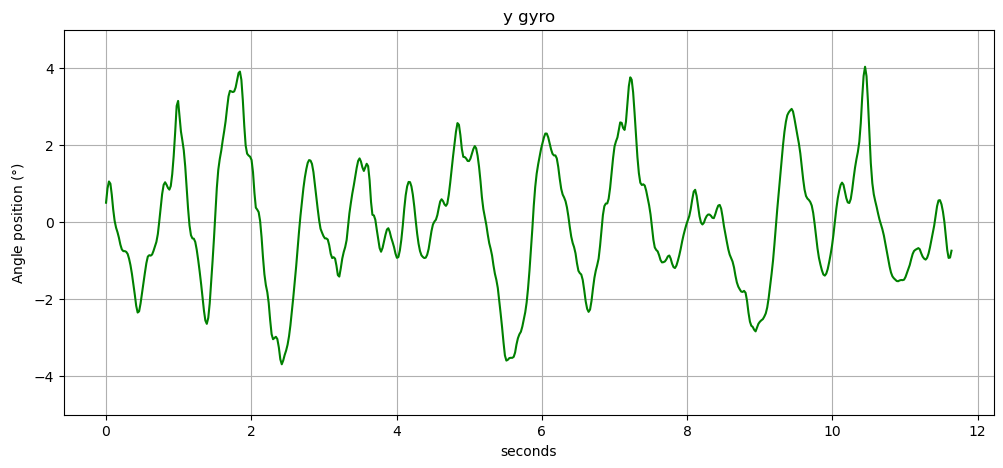

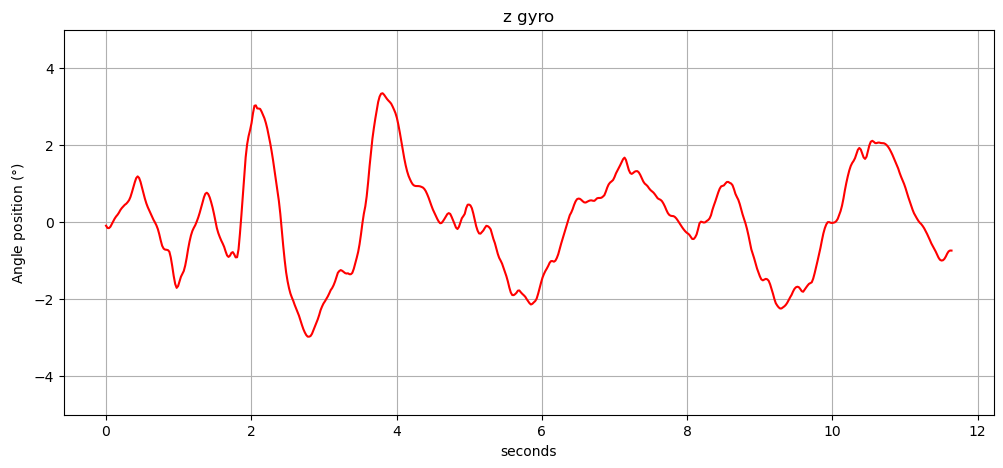

In [11]:
gyro_x_int2 = gyro_x_filt.cumsum()/50 # Integrated data, so we can get the (VERY IMPORTANT): ANGULAR POSITION
plot_column(time, gyro_x_int2,-10,10,'X gyro','Angle position ($\degree$)','seconds','blue')

gyro_y_int2 = gyro_y_filt.cumsum()/50 # Integrated data, so we can get the (VERY IMPORTANT): ANGULAR POSITION
plot_column(time, gyro_y_int2,-5,5,'y gyro','Angle position ($\degree$)','seconds','green')

gyro_z_int2 = gyro_z_filt.cumsum()/50 # Integrated data, so we can get the (VERY IMPORTANT): ANGULAR POSITION
plot_column(time, gyro_z_int2,-5,5,'z gyro','Angle position ($\degree$)','seconds','red')

## Mean, STD, miniimi ja maksiimi arvot
- Jokaisesta akselista otettu halutut arvot:

In [12]:
gyro_x_mean = gyro_x_int2.mean()
print(f'Mean X (Gyro)= {gyro_x_mean:.3f}')
gyro_x_std = gyro_x_int2.std()
print(f'STD X (Gyro)= {gyro_x_std:.3f}')
gyro_x_min = gyro_x_int2.min()
print(f'Min X (Gyro)= {gyro_x_min:.3f}')
gyro_x_max = gyro_x_int2.max()
print(f'Max X (Gyro)= {gyro_x_max:.3f}')

gyro_y_mean = gyro_y_int2.mean()
print(f'Mean Y (Gyro)= {gyro_y_mean:.3f}')
gyro_y_std = gyro_y_int2.std()
print(f'STD Y (Gyro)= {gyro_x_std:.3f}')
gyro_y_min = gyro_y_int2.min()
print(f'Min Y (Gyro)= {gyro_x_min:.3f}')
gyro_y_max = gyro_y_int2.max()
print(f'Max Y (Gyro)= {gyro_y_max:.3f}')

gyro_z_mean = gyro_z_int2.mean()
print(f'Mean Z (Gyro)= {gyro_z_mean:.3f}')
gyro_z_std = gyro_z_int2.std()
print(f'STD Z (Gyro)= {gyro_z_std:.3f}')
gyro_z_min = gyro_z_int2.min()
print(f'Min Z (Gyro)= {gyro_z_min:.3f}')
gyro_z_max = gyro_z_int2.max()
print(f'Max Z (Gyro)= {gyro_z_max:.3f}')

Mean X (Gyro)= 0.100
STD X (Gyro)= 3.326
Min X (Gyro)= -7.003
Max X (Gyro)= 6.874
Mean Y (Gyro)= -0.015
STD Y (Gyro)= 3.326
Min Y (Gyro)= -7.003
Max Y (Gyro)= 4.038
Mean Z (Gyro)= 0.027
STD Z (Gyro)= 1.353
Min Z (Gyro)= -2.973
Max Z (Gyro)= 3.350


## Quartaalit:

In [13]:
q = np.quantile(gyro_x_int2, [0.25, 0.50, 0.75])
print('Kvartiilit X akseli(jaettu 4 osaan):')
print(f'25% = {q[0]:7.2f}') # "7" = 7 characters, ".2" = 2 decimal digits, "f" = float number
print(f'50% = {q[1]:7.2f}')
print(f'75% = {q[2]:7.2f}')

q = np.quantile(gyro_y_int2, [0.25, 0.50, 0.75])
print('Kvartiilit Y akseli(jaettu 4 osaan):')
print(f'25% = {q[0]:7.2f}') # "7" = 7 characters, ".2" = 2 decimal digits, "f" = float number
print(f'50% = {q[1]:7.2f}')
print(f'75% = {q[2]:7.2f}')

q = np.quantile(gyro_z_int2, [0.25, 0.50, 0.75])
print('Kvartiilit Z akseli(jaettu 4 osaan):')
print(f'25% = {q[0]:7.2f}') # "7" = 7 characters, ".2" = 2 decimal digits, "f" = float number
print(f'50% = {q[1]:7.2f}')
print(f'75% = {q[2]:7.2f}')

Kvartiilit X akseli(jaettu 4 osaan):
25% =   -2.06
50% =    0.16
75% =    2.18
Kvartiilit Y akseli(jaettu 4 osaan):
25% =   -1.01
50% =   -0.09
75% =    1.03
Kvartiilit Z akseli(jaettu 4 osaan):
25% =   -0.94
50% =    0.05
75% =    0.90


## Kuvaajan tunaaminen:
 - käytin edellinen funktiota ("plot_column") ja lisäsin siihen erilaisia parametria Signaalinkäsittelyä notebookista. Nyt kun uusi funktio käytetään lukija saa lisää tietoa kuvaajista.

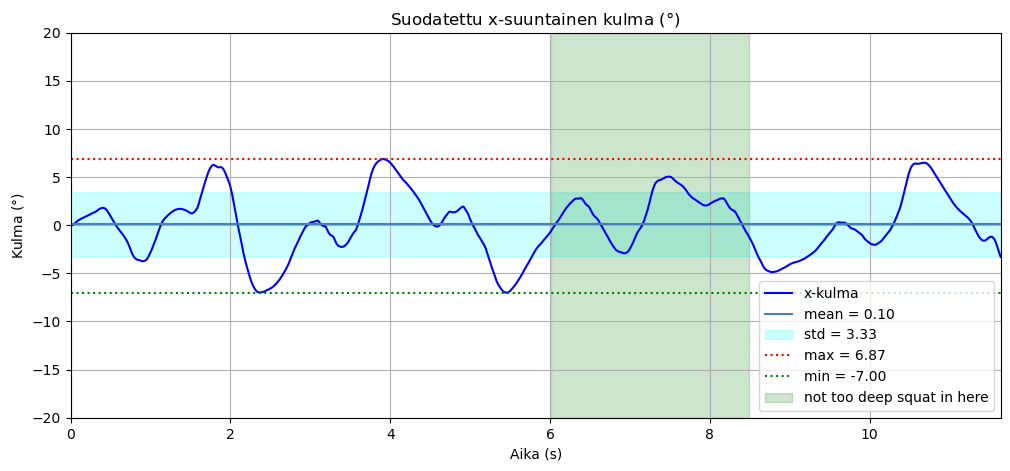

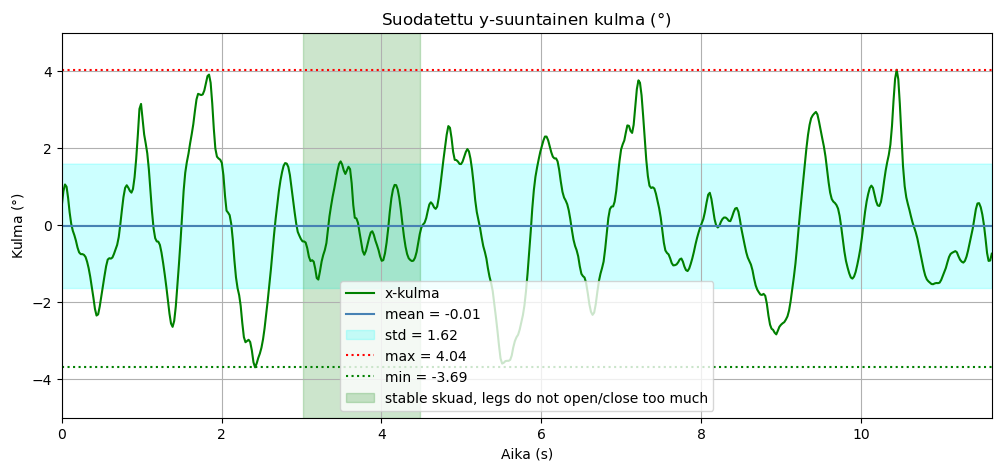

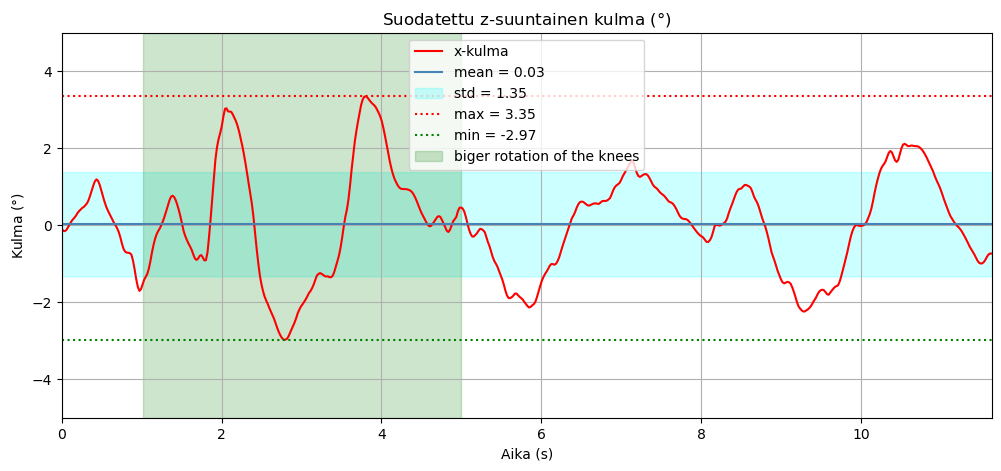

In [14]:
def plot_column_fancy(time, column, ymin, ymax, title, ylabel, xlabel, 
                      mean=None, std=None, wmax=None, wmin=None, 
                      shade_range=None, shade_color='green', shade_alpha=0.2, 
                      shade_label='Shade Area', line_color='blue'):
    plt.plot(time, column, label='x-kulma', color=line_color)

    if mean is not None:
        plt.axhline(mean, color='steelblue', label=f'mean = {mean:.2f}')
    if std is not None:
        plt.fill_between(time, mean-std, mean+std, alpha=0.2, color='cyan', label=f'std = {std:.2f}')
    if wmax is not None:
        plt.axhline(wmax, color='red', linestyle=':', label=f'max = {wmax:.2f}')
    if wmin is not None:
        plt.axhline(wmin, color='green', linestyle=':', label=f'min = {wmin:.2f}')
    if shade_range is not None:
        plt.fill_between(time, 0, 1, 
                         where=(time > shade_range[0]) & (time < shade_range[1]),
                         color=shade_color, 
                         alpha=shade_alpha, 
                         transform=plt.gca().get_xaxis_transform(),
                         label=shade_label)

    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.xlim(time.values[0], time.values[-1])
    plt.ylim(ymin, ymax)
    plt.show()
    
    


plot_column_fancy(
    time=time, 
    column=gyro_x_int2, 
    ymin=-20, 
    ymax=20, 
    title='Suodatettu x-suuntainen kulma ($\degree$)',
    ylabel='Kulma ($\degree$)', 
    xlabel='Aika (s)', 
    mean=gyro_x_mean, 
    std=gyro_x_std, 
    wmax=gyro_x_max, 
    wmin=gyro_x_min, 
    shade_range=[6, 8.5], 
    shade_color='green', 
    shade_alpha=0.2,
    shade_label='not too deep squat in here',
    line_color='blue'
)

plot_column_fancy(
    time=time, 
    column=gyro_y_int2, 
    ymin=-5, 
    ymax=5, 
    title='Suodatettu y-suuntainen kulma ($\degree$)',
    ylabel='Kulma ($\degree$)', 
    xlabel='Aika (s)', 
    mean=gyro_y_mean, 
    std=gyro_y_std, 
    wmax=gyro_y_max, 
    wmin=gyro_y_min, 
    shade_range=[3, 4.5], 
    shade_color='green', 
    shade_alpha=0.2,
    shade_label='stable skuad, legs do not open/close too much',
    line_color='green'
)

plot_column_fancy(
    time=time, 
    column=gyro_z_int2, 
    ymin=-5, 
    ymax=5, 
    title='Suodatettu z-suuntainen kulma ($\degree$)',
    ylabel='Kulma ($\degree$)', 
    xlabel='Aika (s)', 
    mean=gyro_z_mean, 
    std=gyro_z_std, 
    wmax=gyro_z_max, 
    wmin=gyro_z_min, 
    shade_range=[1, 5], 
    shade_color='green', 
    shade_alpha=0.2,
    shade_label='biger rotation of the knees',
    line_color='red'
)


## Histogrammi

## Miten sitä luetaan?
- Calculating Probability: To find the actual probability of a data point falling within a certain range, you would multiply the density by the width of that range. For example, if the bin containing -2.5 extends from -2.75 to -2.25 (a width of 0.5), the probability of a data point falling in this bin is approximately 0.05 * 0.5 = 0.025 or 2.5%.

- Tein funktion joka luo histrogrammia. Tällä tavalla on helppo muokata vain parametrir funktion kutsumisessa. Koodi funktiosta tulee seuraavaksi:

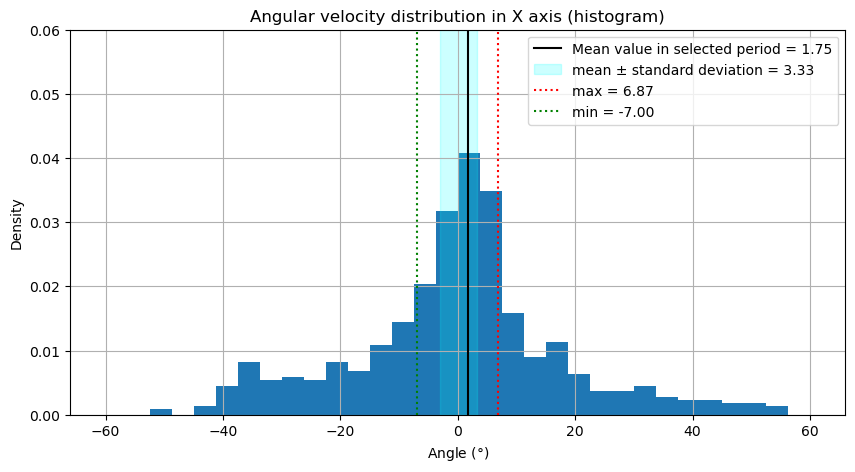

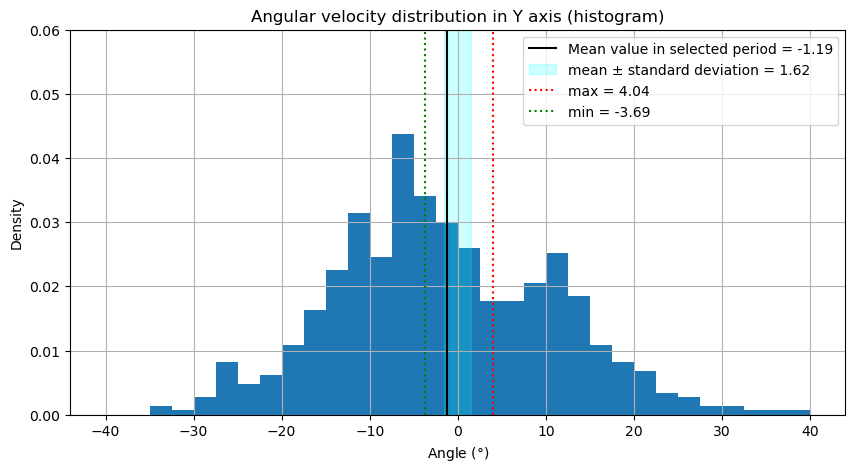

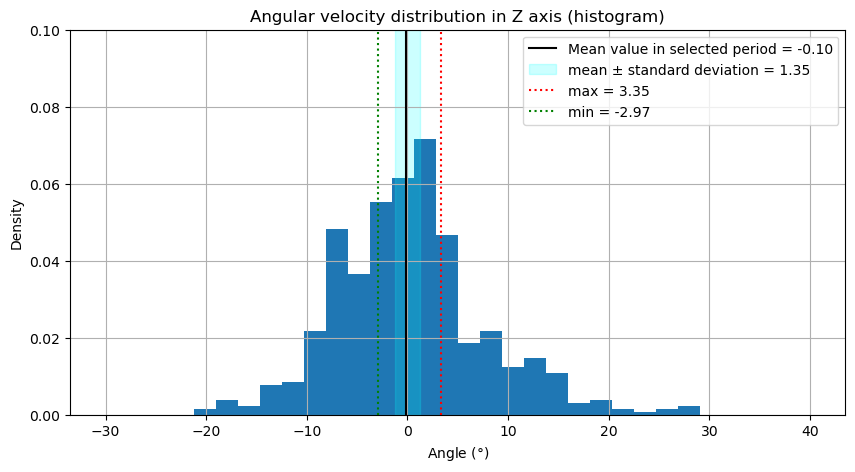

In [15]:


        
def plot_histogram(data, ka, mean, std, wmax, wmin, xmin, xmax, bins, density, ylim_min, ylim_max, xlabel, ylabel, title):
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=np.linspace(xmin, xmax, bins), density=density)
    plt.axvline(ka, color='k', label=f'Mean value in selected period = {ka:.2f}')

    kulma = np.linspace(xmin, xmax, 500)
    plt.fill_between(kulma, 0, 1, where=(kulma >= mean-std) & (kulma <= mean+std), color='cyan', alpha=0.2, label=f'mean ± standard deviation = {std:.2f}')

    plt.axvline(wmax, color='red', linestyle=':', label=f'max = {wmax:.2f}')
    plt.axvline(wmin, color='green', linestyle=':', label=f'min = {wmin:.2f}')

    plt.ylim(ylim_min, ylim_max)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


plot_histogram(
    data=gyro_x, 
    ka=ka_x, 
    mean=gyro_x_mean, 
    std=gyro_x_std, 
    wmax=gyro_x_max, 
    wmin=gyro_x_min, 
    xmin=-60, 
    xmax=60, 
    bins=33, 
    density=True, 
    ylim_min=0, 
    ylim_max=0.06, 
    xlabel='Angle ($\degree$)', 
    ylabel='Density', 
    title='Angular velocity distribution in X axis (histogram)'
)


plot_histogram(
    data=gyro_y, 
    ka=ka_y, 
    mean=gyro_y_mean, 
    std=gyro_y_std, 
    wmax=gyro_y_max, 
    wmin=gyro_y_min, 
    xmin=-40, 
    xmax=40, 
    bins=33, 
    density=True, 
    ylim_min=0, 
    ylim_max=0.06, 
    xlabel='Angle ($\degree$)', 
    ylabel='Density', 
    title='Angular velocity distribution in Y axis (histogram)'
)

plot_histogram(
    data=gyro_z, 
    ka=ka_z, 
    mean=gyro_z_mean, 
    std=gyro_z_std, 
    wmax=gyro_z_max, 
    wmin=gyro_z_min, 
    xmin=-30, 
    xmax=40, 
    bins=33, 
    density=True, 
    ylim_min=0, 
    ylim_max=0.1, 
    xlabel='Angle ($\degree$)', 
    ylabel='Density', 
    title='Angular velocity distribution in Z axis (histogram)'
)


# Kiitos ja näkemiin :)